In [1]:
# Import necessary libraries
from numpy import array
import pandas as pd
import numpy as np
from datetime import datetime
from numpy import asarray
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
import random
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import pickle
import csv
from dateutil.relativedelta import relativedelta

In [2]:
# Read CPI data from CSV file
gdp_2007_2023 = pd.read_csv('../input_data/gpd_data_Jan2007_Sept2023.csv')

# Extract Year and Month from 'Dates' column
gdp_2007_2023['Month'] = gdp_2007_2023['Dates'].str.split('-').str[0].astype('str')
gdp_2007_2023['Year'] = gdp_2007_2023['Dates'].str.split('-').str[1].astype('str')

# Create a new column 'FormattedDate' in the desired format
gdp_2007_2023['FormattedDate'] = pd.to_datetime(gdp_2007_2023['Month'] + ' ' + gdp_2007_2023['Year'], format='%b %y').dt.strftime('%m/%d/%Y %H:%M')
gdp_2007_2023['Dates'] = gdp_2007_2023['FormattedDate']
gdp_2007_2023 = gdp_2007_2023.drop(columns=['Month', 'Year', 'FormattedDate'])

gdp_2007_2023.rename(columns={'Monthly GDP':'GDP'}, inplace=True)
# Setting idex as Dates column
gdp_2007_2023.set_index('Dates', inplace=True)
gdp_2007_2023.tail()

,GDP
Dates,
03/01/2023 00:00,102.3
04/01/2023 00:00,102.5
05/01/2023 00:00,102.3
06/01/2023 00:00,103.0
07/01/2023 00:00,102.4


In [3]:
# Scale data between -1 and 1
gdp_scaler = MinMaxScaler()
scaled_gdp = asarray(gdp_2007_2023['GDP']).reshape(-1, 1)
scaled_gdp = gdp_scaler.fit_transform(scaled_gdp)
# Omit the last 50 observations for out-of-sample forecast
gdp_sample_forecast_input = scaled_gdp[len(scaled_gdp) - 20:, 0]
scaled_gdp = scaled_gdp[:len(scaled_gdp) - 20, 0]

# let's transform our remaning data into a univariate supervised learning problem
# Functions transforms our time series sequence into a supervised leaning problem
# Transform data into a univariate supervised learning problem
def split_sequences(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence) - (n_steps_in + n_steps_out)):
        append_X = []
        append_y = []
        for j in range(n_steps_in):
            append_X.append(sequence[i + j])
        for k in range(n_steps_out):
            append_y.append(sequence[i + n_steps_in + k + 1])

        X.append(append_X)
        y.append(append_y)

    return np.array(X), np.array(y)

In [4]:
# Set the number of lags and forecast periods
n_steps_in = 20
n_steps_out = 12

# Create sequences for input (X) and output (y)
X, y = split_sequences(scaled_gdp, n_steps_in, n_steps_out)

# Split data into training and testing 80:20
total_rows = X.shape[0]
train_rows = int(total_rows * 0.8)
test_rows = total_rows - train_rows

# Obtain training and testing data
X_train = X[:train_rows]
X_test = X[train_rows:]
y_train = y[:train_rows]
y_test = y[train_rows:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [5]:
# Build and train the LSTM model

# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer with 75 units, ReLU activation, and input shape (n_steps_in, 1)
# Return sequences as there is another LSTM layer following
model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1)))

# Add the second LSTM layer with 75 units and ReLU activation
# Does not return sequences as it is the final LSTM layer
model.add(LSTM(75, activation='relu', return_sequences=False))

# Add a dropout layer with a dropout rate of 0.2 to prevent overfitting
model.add(Dropout(0.5))

# Add a dense (fully connected) layer with n_steps_out units for prediction
model.add(Dense(n_steps_out))

# Experiment with different learning rates. 
# Trying reducing the learning rate to allow the model to converge more slowly and potentially reach a better minimum.
# optimizer = Adam(lr=0.001)

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss='mse', optimizer='adam')

training_model = model.fit(X_train, y_train, epochs=50, verbose=1)

Epoch 1/50
4/4 [==============================] - 6s 114ms/step - loss: 0.3173
Epoch 2/50
4/4 [==============================] - 0s 97ms/step - loss: 0.2899
Epoch 3/50
4/4 [==============================] - 0s 35ms/step - loss: 0.2575
Epoch 4/50
4/4 [==============================] - 0s 37ms/step - loss: 0.2062
Epoch 5/50
4/4 [==============================] - 0s 34ms/step - loss: 0.1630
Epoch 6/50
4/4 [==============================] - 0s 28ms/step - loss: 0.1230
Epoch 7/50
4/4 [==============================] - 0s 51ms/step - loss: 0.0967
Epoch 8/50
4/4 [==============================] - 0s 30ms/step - loss: 0.0790
Epoch 9/50
4/4 [==============================] - 0s 31ms/step - loss: 0.0754
Epoch 10/50
4/4 [==============================] - 0s 30ms/step - loss: 0.0624
Epoch 11/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0653
Epoch 12/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0535
Epoch 13/50
4/4 [==============================] - 0s 35ms/s

In [6]:
# Perform out-of-sample forecast
gdp_sample_forecast_input = asarray(gdp_sample_forecast_input).reshape(1, n_steps_in)
dpg_sample_forecast = model.predict(gdp_sample_forecast_input, verbose=0)

# Inversely scale the forecasted data and save it to a CSV file
gdp_list_forecast = gdp_scaler.inverse_transform(dpg_sample_forecast).tolist()
print('Predicted CPIH Data for next 12 months: ', gdp_list_forecast[0])

# Inversely scale the forecasted data and save it to a CSV file
gdp_list_actual_20 = gdp_scaler.inverse_transform(gdp_sample_forecast_input).tolist()
print('Actual last 20 Months CPIH data: ', gdp_list_actual_20[0])

# Creating list of data
gdp_latestdata = gdp_list_actual_20[0]
gdp_prediction = gdp_list_forecast[0]
gdp_prediction.insert(0, gdp_latestdata[-1])

Predicted CPIH Data for next 12 months:  [104.1611099243164, 104.95350646972656, 104.9898681640625, 105.26239013671875, 105.8651123046875, 105.98714447021484, 107.06043243408203, 106.06903076171875, 106.23019409179688, 106.58960723876953, 107.81211853027344, 109.1224594116211]
Actual last 20 Months CPIH data:  [100.9, 101.4, 102.0, 102.1, 101.9, 102.6, 101.6, 102.0, 102.1, 101.5, 102.1, 102.2, 101.9, 102.4, 102.6, 102.3, 102.5, 102.3, 103.0, 102.4]


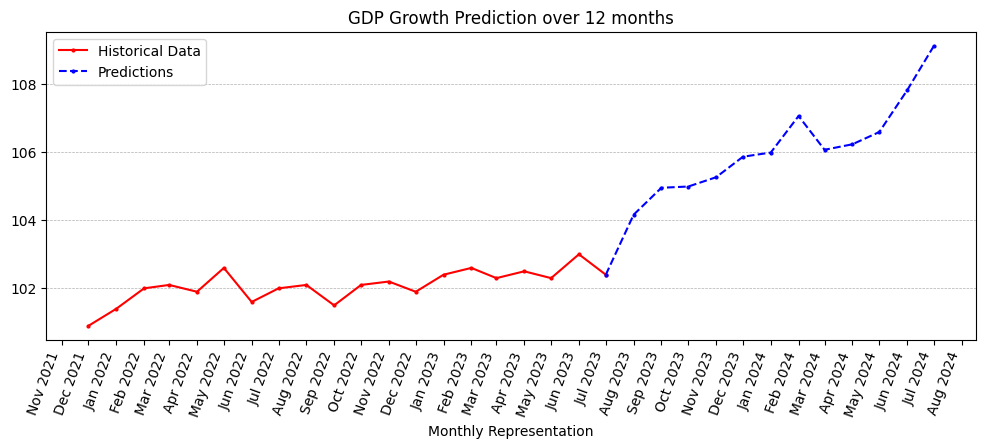

In [7]:
# Assuming 'latestdata' and 'prediction' are lists of corresponding values
month = 12
s = '12/2021'

# Generate date ranges for plotting
x1 = [datetime.strptime(s, '%m/%Y') + relativedelta(months=i) for i in range(20)]
x2 = [datetime.strptime(s, '%m/%Y') + relativedelta(months=19 + i) for i in range(month + 1)]

# Ensure that the lengths of x1 and x2 match the lengths of latestdata and prediction
x1 = x1[:len(gdp_latestdata)]
x2 = x2[:len(gdp_prediction)]


# Increase the width of the graph by setting the figsize parameter
plt.figure(figsize=(12, 4))  # Adjust the width (12 inches) and height (4 inches) as needed

# Plotting
plt.plot(x1, gdp_latestdata, 'r', label='Historical Data', marker='o', markersize=2)
plt.plot(x2, gdp_prediction, 'b--', label='Predictions', marker='o', markersize=2)
plt.xticks(rotation=70, ha="right")  # Adjust rotation for better readability


# Set x-axis ticks to display monthly
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Set ticks at every month
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))  # Format tick labels

# Add a blurred grid
# plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0, rasterized=True)
# Add horizontal grid lines
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, zorder=0, rasterized=True)

plt.title('GDP Growth Prediction over {} months'.format(month))
plt.xlabel('Monthly Representation')
plt.legend()
plt.show()